# Import Library & Port Forward

## Fetching Data from MySQL into a Pandas DataFrame

### Setup

Beberapa paket yang harus diinstall sebelum menjalankan program.
Anda bisa menginstall paket dibawah ini pada anaconda prompt atau jupyter notebook

paket `mysql-connector-python` untuk menyambung ke basis data MySQL dan paket `pandas` untuk bekerja dengan DataFrames
```bash
pip install mysql-connector-python
```

In [ ]:
# install mysql connector di jupyter notebook
# !pip install mysql-connector-python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mysql.connector
from mysql.connector import Error

# import warning to ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# function to open connection to db
def connect_to_db(host_name, port_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [ ]:
# define mysql details
host   = 'okegarden-laravel-prod-db-2024-11-15-0200.cgwhhgh85mr3.ap-southeast-3.rds.amazonaws.com'
port   = 3306
user   = 'intern_mes'
passwd = 'sdfDFLES342982Ddlsdksd'
databs = 'okegarden_laravel_prod_db'

In [ ]:
# try to connect to sakila database
connect_to_db(host, port, user, passwd, databs)

MySQL Database connection successful


## Writing the Function to Fetch Data

In [ ]:
# function to fetch data from database, the connection is closed after use.
def fetch_data(host_name, port_name, user_name, user_password, db_name, query, params=None):
    try:
        # use with to ensure the connection is closed after use
        with mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            password=user_password,
            database=db_name
        ) as connection:
            data = pd.read_sql(query, connection, params=params) # read the query to dataframe format
            return data

    except Error as e:
        print(f"Error while connecting to MySQL or fetching data: {e}")
        return None

# Assessing Data

In [ ]:
# usage example (the mysql detail already defined)
# simple query
master_query = """

SELECT
   DATE(order_garden.created_at) AS date,
   order_garden.id_order,
   order_garden.id_user,
   design.design_name,
   order_garden.size_area,
   CASE
       WHEN order_garden.price = 0 THEN order_garden.total_promo
       ELSE order_garden.price
   END AS price,
   desc_design.total_item_cost,
   CASE
       WHEN order_garden.size_area <= 10 THEN 2
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5
       ELSE 5
   END AS jumlah_tenaga_kerja,
   CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END AS total_biaya_tenaga_kerja,
   (CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END + desc_design.total_item_cost) AS total_cost,
   ((CASE
       WHEN order_garden.price = 0 THEN order_garden.total_promo
       ELSE order_garden.price
   END) -
   (CASE
       WHEN order_garden.size_area <= 10 THEN 2 * 250000
       WHEN order_garden.size_area BETWEEN 11 AND 20 THEN 3 * 250000
       WHEN order_garden.size_area BETWEEN 21 AND 30 THEN 4 * 250000
       WHEN order_garden.size_area BETWEEN 31 AND 40 THEN 5 * 250000
       WHEN order_garden.size_area BETWEEN 41 AND 50 THEN 5 * 250000
       ELSE 5 * 250000
   END + desc_design.total_item_cost)) AS revenue,
   order_garden.status,
   order_garden.id_gardener,
   u.name,
   address_components.administrative_area_level_1 AS province_name,
   address_components.administrative_area_level_2 AS city_name,
   address_components.administrative_area_level_3 AS district
FROM
   `order_garden`
JOIN
   `design` on design.id_design = order_garden.id_design_finish
LEFT JOIN
   (
       SELECT
           id_design,
           SUM(item_total_cost) AS total_item_cost
       FROM
           desc_design
       GROUP BY
           id_design
   ) desc_design ON design.id_design = desc_design.id_design
LEFT JOIN
   `user` u on order_garden.id_gardener = u.id_user
LEFT JOIN
   `address_components` on order_garden.province = address_components.id
WHERE
	order_garden.status != "expired"
	AND
	order_garden.id_user >= 250;

"""

In [ ]:
# fetch data using function
df = fetch_data(host, port, user, passwd, databs, master_query)

In [ ]:
# show data
df.head()

,date,id_order,id_user,design_name,size_area,price,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,total_cost,revenue,status,id_gardener,name,province_name,city_name,district
0,2024-04-23,65,927,Taman Regina,11.0,9230382.0,4463700.0,3,750000,5213700.0,4016682.0,in_review,1087.0,ODIH,Daerah Khusus Ibukota Jakarta,Jakarta Selatan,Jagakarsa
1,2024-04-27,66,926,Taman Susy,28.0,6581190.0,2646250.0,4,1000000,3646250.0,2934940.0,in_review,1093.0,Budi Wahyudi,Jakarta,East Jakarta City,Durensawit
2,2024-05-16,70,925,Taman Lintang R,35.0,11550859.0,3931899.0,5,1250000,5181899.0,6368960.0,finish,1085.0,Ari aryana,Daerah Khusus Ibukota Jakarta,Jakarta Selatan,Jagakarsa
3,2024-05-24,72,1024,Taman Nopri,2.0,5440942.0,2987200.0,2,500000,3487200.0,1953742.0,finish,1087.0,ODIH,West Java,Bekasi Regency,Tambun Selatan
4,2024-06-12,74,1052,Taman Nur Atikah,5.0,4334875.0,2331500.0,2,500000,2831500.0,1503375.0,finish,1087.0,ODIH,Daerah Khusus Ibukota Jakarta,Jakarta Selatan,Jagakarsa


In [ ]:
# show info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      107 non-null    object 
 1   id_order                  107 non-null    int64  
 2   id_user                   107 non-null    int64  
 3   design_name               107 non-null    object 
 4   size_area                 107 non-null    float64
 5   price                     107 non-null    float64
 6   total_item_cost           107 non-null    float64
 7   jumlah_tenaga_kerja       107 non-null    int64  
 8   total_biaya_tenaga_kerja  107 non-null    int64  
 9   total_cost                107 non-null    float64
 10  revenue                   107 non-null    float64
 11  status                    107 non-null    object 
 12  id_gardener               99 non-null     float64
 13  name                      99 non-null     object 
 14  province_n

## Missing Values

In [ ]:
df.isna().sum()

,0
date,0
id_order,0
id_user,0
design_name,0
size_area,0
price,0
total_item_cost,0
jumlah_tenaga_kerja,0
total_biaya_tenaga_kerja,0
total_cost,0


## Duplicates

In [ ]:
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  0


## Outliers

In [ ]:
df_num = df.select_dtypes(include =['int64', 'float64'])

In [ ]:
# function to find outliers, using numpy
def find_outlier(data):
    # find quantile
    Q1 = np.quantile(data, .25)
    Q2 = np.quantile(data, .50) # median
    Q3 = np.quantile(data, .75)

    # find IQR
    IQR = (Q3 - Q1) * 1.5
    lower_limit = Q1 - IQR
    upper_limit = Q3 + IQR

    # find outlier
    outlier = ''
    for i in range(len(data)):
        if data[i] > upper_limit:
            outlier = outlier + str(data[i]) + ', '

        elif data[i] < lower_limit:
            outlier = outlier + str(data[i]) + ', '

    return outlier

In [ ]:
# detect outliers from each columns using loop
for i in df_num:
    val = df_num[i].sort_values().values.tolist()
    print(f"Outliers Detected {i}: ", len(find_outlier(val)))

Outliers Detected id_order:  0
Outliers Detected id_user:  0
Outliers Detected size_area:  70
Outliers Detected price:  132
Outliers Detected total_item_cost:  142
Outliers Detected jumlah_tenaga_kerja:  36
Outliers Detected total_biaya_tenaga_kerja:  108
Outliers Detected total_cost:  120
Outliers Detected revenue:  132
Outliers Detected id_gardener:  0


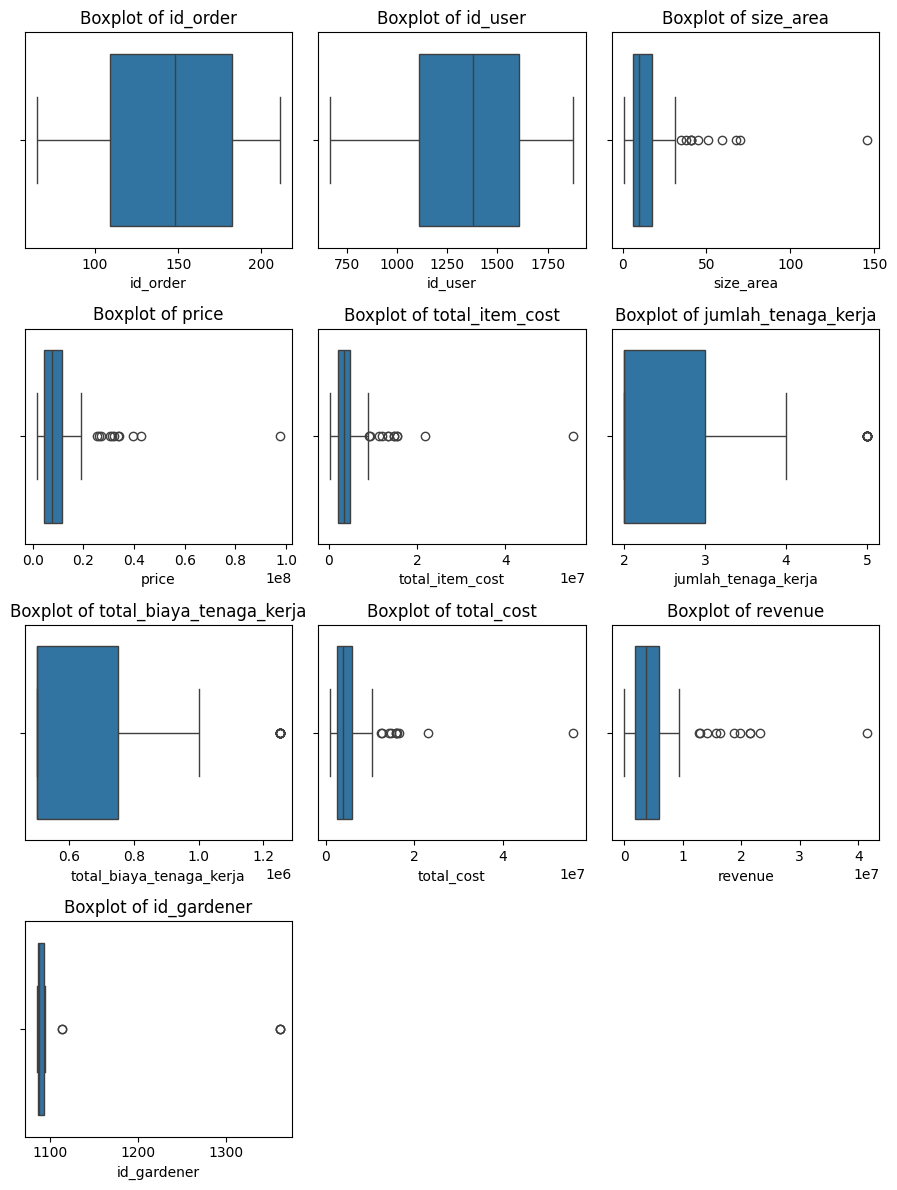

In [ ]:
# Set the number of plots
num_cols = 3  # Number of columns per row
num_rows = (len(df_num.columns) + num_cols - 1) // num_cols  # Count the number of rows required
plt.figure(figsize=(3 * num_cols, 3 * num_rows))  # Set image size

for i, column in enumerate(df_num.columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Creating a subplot
    sns.boxplot(data=df_num, x=column)
    plt.title(f"Boxplot of {column}")

plt.tight_layout()  # Arrange the layout so that it doesn't overlap
plt.show()

# Cleaning & Data Transformation

### Type casting

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['price'] = df['price'].astype('int64')

In [ ]:
df['total_item_cost'] = df['total_item_cost'].astype('int64')

In [ ]:
df['total_cost'] = df['total_cost'].astype('int64')

In [ ]:
df['revenue'] = df['revenue'].astype('int64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      107 non-null    datetime64[ns]
 1   id_order                  107 non-null    int64         
 2   id_user                   107 non-null    int64         
 3   design_name               107 non-null    object        
 4   size_area                 107 non-null    float64       
 5   price                     107 non-null    int64         
 6   total_item_cost           107 non-null    int64         
 7   jumlah_tenaga_kerja       107 non-null    int64         
 8   total_biaya_tenaga_kerja  107 non-null    int64         
 9   total_cost                107 non-null    int64         
 10  revenue                   107 non-null    int64         
 11  status                    107 non-null    object        
 12  id_gardener           

### Handling Missing Values

In [ ]:
df['id_gardener'] = df['id_gardener'].fillna(0)
df['id_gardener'] = df['id_gardener'].astype('int64')

In [ ]:
df['name'] = df['name'].fillna('none')

In [ ]:
df.isna().sum()

,0
date,0
id_order,0
id_user,0
design_name,0
size_area,0
price,0
total_item_cost,0
jumlah_tenaga_kerja,0
total_biaya_tenaga_kerja,0
total_cost,0


### Transformation

In [ ]:
province_transform = {
    'Daerah Khusus Ibukota Jakarta': 'DKI Jakarta',
    'West Java': 'Jawa Barat'
    }

city_transform = {
    'East Jakarta City': 'Jakarta Timur',
    'Bekasi Regency': 'Bekasi',
    'South Tangerang City': 'Tanggerang Selatan',
}

In [ ]:
df['province_name'] = df['province_name'].replace(province_transform)
df['city_name'] = df['city_name'].replace(city_transform)

# Exploratory Data Analysis (EDA)

## Descriptive Analysis

In [ ]:
df.describe()

,date,id_order,id_user,size_area,price,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,total_cost,revenue,id_gardener
count,107,107.000000,107.000000,107.000000,1.070000e+02,1.070000e+02,107.000000,1.070000e+02,1.070000e+02,1.070000e+02,107.000000
mean,2024-08-30 04:15:42.056074752,144.121495,1390.336449,15.333411,1.076089e+07,4.929688e+06,2.822430,7.056075e+05,5.635295e+06,5.125591e+06,1015.495327
min,2024-04-23 00:00:00,65.000000,670.000000,1.000000,1.625150e+06,3.570000e+05,2.000000,5.000000e+05,1.087700e+06,1.815000e+04,0.000000
25%,2024-07-21 00:00:00,109.000000,1110.500000,6.000000,4.565635e+06,2.105500e+06,2.000000,5.000000e+05,2.641090e+06,1.779449e+06,1085.000000
50%,2024-08-28 00:00:00,148.000000,1377.000000,10.000000,7.708500e+06,3.350450e+06,2.000000,5.000000e+05,3.990675e+06,3.676021e+06,1087.000000
75%,2024-10-13 00:00:00,182.500000,1608.500000,17.500000,1.177293e+07,4.861500e+06,3.000000,7.500000e+05,5.936650e+06,5.977554e+06,1092.500000
max,2024-11-14 00:00:00,211.000000,1878.000000,145.725000,9.741224e+07,5.539690e+07,5.000000,1.250000e+06,5.589690e+07,4.151534e+07,1361.000000
std,NaN,42.851589,287.261368,18.610515,1.190295e+07,6.187656e+06,1.026195,2.565489e+05,6.257959e+06,5.966180e+06,293.538059


In [ ]:
df.select_dtypes(['number']).mean()

,0
id_order,1.441215e+02
id_user,1.390336e+03
size_area,1.533341e+01
price,1.076089e+07
total_item_cost,4.929688e+06
jumlah_tenaga_kerja,2.822430e+00
total_biaya_tenaga_kerja,7.056075e+05
total_cost,5.635295e+06
revenue,5.125591e+06
id_gardener,1.015495e+03


In [ ]:
df.select_dtypes(['number']).median()

,0
id_order,148.0
id_user,1377.0
size_area,10.0
price,7708500.0
total_item_cost,3350450.0
jumlah_tenaga_kerja,2.0
total_biaya_tenaga_kerja,500000.0
total_cost,3990675.0
revenue,3676021.0
id_gardener,1087.0


In [ ]:
df.select_dtypes(['number']).mode()

,id_order,id_user,size_area,price,total_item_cost,jumlah_tenaga_kerja,total_biaya_tenaga_kerja,total_cost,revenue,id_gardener
0,65,1842.0,11.0,8912900.0,4218600.0,2.0,500000.0,4968600.0,3944300.0,1085.0
1,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
102,207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Range

In [ ]:
df.select_dtypes(['number']).max() - df.select_dtypes(['number']).min()

,0
id_order,1.460000e+02
id_user,1.208000e+03
size_area,1.447250e+02
price,9.578709e+07
total_item_cost,5.503990e+07
jumlah_tenaga_kerja,3.000000e+00
total_biaya_tenaga_kerja,7.500000e+05
total_cost,5.480920e+07
revenue,4.149719e+07
id_gardener,1.361000e+03


In [ ]:
print(df['size_area'].max(), df['size_area'].min())
print("Range of size_area :", df['size_area'].max() - df['size_area'].min())

145.725 1.0
Range of size_area : 144.725


In [ ]:
print(df['price'].max(), df['price'].min())
print("Range of price :", df['price'].max() - df['price'].min())

97412240 1625150
Range of price : 95787090


In [ ]:
print(df['total_item_cost'].max(), df['total_item_cost'].min())
print("Range of total_item_cost :", df['total_item_cost'].max() - df['total_item_cost'].min())

55396899 357000
Range of total_item_cost : 55039899


In [ ]:
print(df['jumlah_tenaga_kerja'].max(), df['jumlah_tenaga_kerja'].min())
print("Range of jumlah_tenaga_kerja :", df['jumlah_tenaga_kerja'].max() - df['jumlah_tenaga_kerja'].min())

5 2
Range of jumlah_tenaga_kerja : 3


In [ ]:
print(df['total_biaya_tenaga_kerja'].max(), df['total_biaya_tenaga_kerja'].min())
print("Range of total_biaya_tenaga_kerja :", df['total_biaya_tenaga_kerja'].max() - df['total_biaya_tenaga_kerja'].min())

1250000 500000
Range of total_biaya_tenaga_kerja : 750000


In [ ]:
print(df['total_cost'].max(), df['total_cost'].min())
print("Range of total_cost :", df['total_cost'].max() - df['total_cost'].min())

55896899 1087700
Range of total_cost : 54809199


In [ ]:
print(df['revenue'].max(), df['revenue'].min())
print("Range of revenue :", df['revenue'].max() - df['revenue'].min())

41515341 18150
Range of revenue : 41497191


### Standard Deviation

In [ ]:
df.select_dtypes(['number']).std()

,0
id_order,4.285159e+01
id_user,2.872614e+02
size_area,1.861051e+01
price,1.190295e+07
total_item_cost,6.187656e+06
jumlah_tenaga_kerja,1.026195e+00
total_biaya_tenaga_kerja,2.565489e+05
total_cost,6.257959e+06
revenue,5.966180e+06
id_gardener,2.935381e+02


### Variance

In [ ]:
df.select_dtypes(['number']).var()

,0
id_order,1.836259e+03
id_user,8.251909e+04
size_area,3.463513e+02
price,1.416803e+14
total_item_cost,3.828709e+13
jumlah_tenaga_kerja,1.053077e+00
total_biaya_tenaga_kerja,6.581732e+10
total_cost,3.916205e+13
revenue,3.559531e+13
id_gardener,8.616459e+04


### Distribution

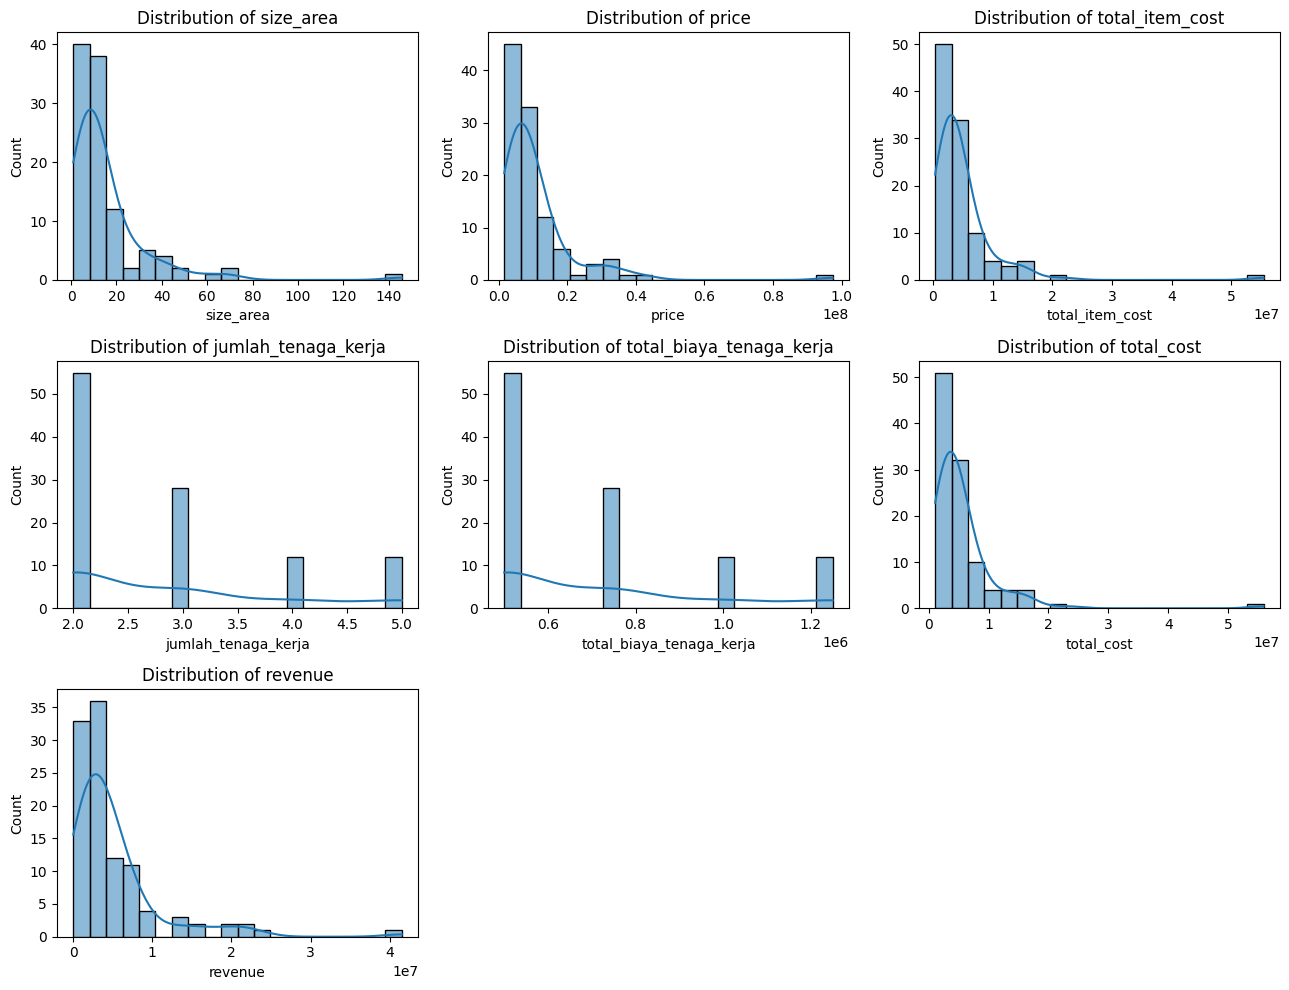

In [ ]:
plt.figure(figsize=(13, 10))

plt.subplot(3, 3, 1)
sns.histplot(df['size_area'], bins=20, kde=True)
plt.title('Distribution of size_area')

plt.subplot(3, 3, 2)
sns.histplot(df['price'], bins=20, kde=True)
plt.title('Distribution of price')

plt.subplot(3, 3, 3)
sns.histplot(df['total_item_cost'], bins=20, kde=True)
plt.title('Distribution of total_item_cost')

plt.subplot(3, 3, 4)
sns.histplot(df['jumlah_tenaga_kerja'], bins=20, kde=True)
plt.title('Distribution of jumlah_tenaga_kerja')

plt.subplot(3, 3, 5)
sns.histplot(df['total_biaya_tenaga_kerja'], bins=20, kde=True)
plt.title('Distribution of total_biaya_tenaga_kerja')

plt.subplot(3, 3, 6)
sns.histplot(df['total_cost'], bins=20, kde=True)
plt.title('Distribution of total_cost')

plt.subplot(3, 3, 7)
sns.histplot(df['revenue'], bins=20, kde=True)
plt.title('Distribution of revenue')

plt.tight_layout()
plt.show()

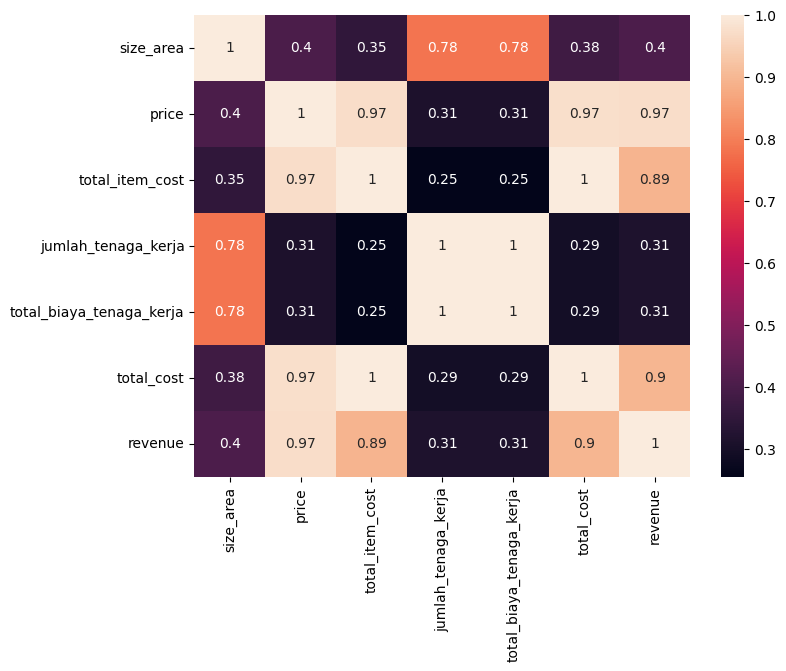

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["size_area", "price", "total_item_cost", "jumlah_tenaga_kerja", "total_biaya_tenaga_kerja", "total_cost", "revenue"]].corr(), annot= True)
plt.show()

# Insight

- insight 1
- insight 2
- ....

# Conclusion

- Conclution insight 1
- Conclution insight 2
- ....